> 特征的好坏决定了模型的上限，而不断优化的算法只是在逼近这个上限。

所以在一个实际案例中，数据清洗、EDA和特征工程是最耗时，也是最重要的部分。下面是对我近期看到和总结的特征工程技巧的梳理，制作成手册，以备随时翻阅。

## 正文

### 数据分析
数据分析可能涉及以下方面：
- 分析特征变量的分布
    - 特征变量为连续值：如果为**长尾分布**并且考虑使用**线性模型**，可以对变量进行**幂变换或者对数变换**。
    - 特征变量为离散值：观察每个离散值的频率分布，**对于频次较低的特征，可以考虑统一编码为“其他”类别**。
- 分析目标变量的分布
    - 目标变量为连续值：查看其值域范围是否较大，如果较大，可以考虑对其进行**对数变换**，并以变换后的值作为新的目标变量进行建模（在这种情况下，需要对预测结果进行逆变换）。一般情况下，可以对连续变量进行**Box-Cox变换**。通过变换可以使得模型更好的优化，通常也会带来效果上的提升。
    - 目标变量为离散值：如果数据分布不平衡，考虑是否需要**上采样/下采样**；如果目标变量在某个ID上面分布不平衡，在划分本地训练集和验证集的时候，需要考虑**分层采样（Stratified Sampling）**。
- 分析变量之间两两的分布和相关度
    - 可以用于发现高相关和共线性的特征。
 
通过对数据进行探索性分析（甚至有些情况下需要肉眼观察样本），还可以有助于启发数据清洗和特征抽取，譬如缺失值和异常值的处理，文本数据是否需要进行拼写纠正等。

### 清洗
- 特征缺失值的处理
    - 特征值为连续值：按不同的分布类型对缺失值进行补全：偏正态分布，使用均值代替，可以保持数据的均值；偏长尾分布，使用中值代替，避免受 outlier 的影响；
    - 特征值为离散值：使用众数代替。

- 文本数据的清洗
    - 在比赛当中，如果数据包含文本，往往需要进行大量的数据清洗工作。如去除HTML 标签，分词，拼写纠正, 同义词替换，去除停词，抽词干，数字和单位格式统一等。

### 特征工程
#### 特征变换
主要针对一些**长尾分布**的特征，需要进行幂变换或者对数变换，使得模型（LR或者DNN）能更好的优化。需要注意的是，Random Forest 和 GBDT 等模型对单调的函数变换不敏感。其原因在于树模型在求解分裂点的时候，只考虑排序分位点。
#### 特征编码
对于离散的类别特征，往往需要进行必要的特征转换/编码才能将其作为特征输入到模型中。  
对于取值较多（如几十万）的类别特征（ID特征），直接进行OneHotEncoder编码会导致特征矩阵非常巨大，影响模型效果。可以使用如下的方式进行处理：
-  统计每个取值在样本中出现的频率，取 Top N 的取值进行 One-hot 编码，剩下的类别分到“其他“类目下，其中 N 需要根据模型效果进行调优；
- 统计每个 ID 特征的一些统计量（譬如历史平均点击率，历史平均浏览率）等代替该 ID 取值作为特征，具体可以参考 Avazu 点击率预估比赛第二名的获奖方案；
- 参考 word2vec 的方式，将每个类别特征的取值映射到一个连续的向量，对这个向量进行初始化，跟模型一起训练。训练结束后，可以同时得到每个ID的Embedding。具体的使用方式，可以参考 Rossmann 销量预估竞赛第三名的获奖方案，https://github.com/entron/entity-embedding-rossmann
 
对于 Random Forest 和 GBDT 等模型，如果类别特征存在较多的取值，可以直接使用 LabelEncoder 后的结果作为特征。

#### 类别特征
##### 类别编码
- One-Hot编码：将K个分类变为K维1-0向量，记得drop掉分类后的第一列，更适合线性模型
- Label编码：将类别对应为数字，Useful for non-linear tree-based algorithms；可以随机多做几组，在训练，查看效果
- Count编码：即频率编码，是将每个类别映射为该类别出现的频次； 
    - Useful for both linear and non-linear algorithms
    - 异常值敏感
    - 可能加上对数变换之后，可以提升性能
    - 把缺失值替换为1
- LabelCount encoding：将类别映射为按照频次排序后的次序
    - 线性/非线性模型都可
    - 异常值不敏感
- NaN编码：额外生成一列，表示是否缺失，缺失为1，否为0
- target编码：Encode categorical variables by their ratio of target (binary classification or regression)
    - 容易造成过拟合
    - 做交叉验证
    - 平滑处理，防止出现0
    - 添加噪声，防止过拟合
    - 线性/非线性均可（ When applied properly: Best encoding for both linear and non-linear）
- Category Embedding：用神经网络创建dense embedding
##### 交叉组合
- 类别+类别：更细的粒度
- 类别与数值：类别不改变

##### 类文本数据
Word2Vec，TF-IDF，LDA等

#### 数值特征
- Rounding：设置精度，如年龄23.223可以设置为23作为一列，2（十位）作为一列
    - 在调整精度前，可以先log-transform
- Binning：分箱，可以兼容离群值。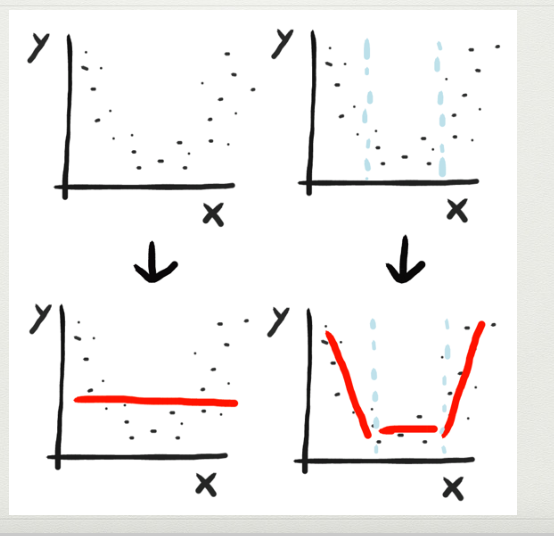
- Scaling：Standard Scaling，MinMax，Root，Log
- 缺失值填充：
    - 均值（正态分布）
    - 中位数（离群值多）
    - 算法预测，将NaN作为label
- 统计特征：均值、极值、中位数、方差、偏度、峰度
- 交叉组合：加减乘除组合

#### 时间特征
- 时间窗口：各种统计方式、均值、方差等
- 时间间隔：距离时间节点的时间差；上次下次时间差；上个月，上周等的数据总和、均值等

#### 其他特征构造
- 样本分析
    - 统计样本中NaN的数量，0的数量，负数的数量，均值，最大值，最小值等等

#### 特征选择

##### 基于模型
使用`feature_importance`或`coef_`可以查看特征重要性
##### 基于递归特征消除（RFE）
递归特征消除（RFE）将机器学习模型的实例和要使用的最终期望特征数作为输入。然后，它递归地减少要使用的特征的数量，采用的方法是使用机器学习模型精度作为度量对它们进行排序。  
创建一个 for 循环，其中输入特征的数量是我们的变量，这样就可以通过跟踪在每个循环迭代中注册的精度，找出我们的模型所需的最佳特征数量。使用 RFE 支持方法，我们可以找出被评估为最重要的特征的名称（rfe.support 返回一个布尔列表，其中 true 表示一个特征被视为重要，false 表示一个特征不重要）。

```python
from sklearn.feature_selection import RFE

model = RandomForestClassifier(n_estimators=700)
rfe = RFE(model, 4)#参数为模型和特征数量期望
start = time.process_time()
RFE_X_Train = rfe.fit_transform(X_Train,Y_Train)
RFE_X_Test = rfe.transform(X_Test)
rfe = rfe.fit(RFE_X_Train,Y_Train)
print(time.process_time() - start)
print("Overall Accuracy using RFE: ", rfe.score(RFE_X_Test,Y_Test))
```

##### 基于Person相关系数选择
这里简单
##### 单变量选择（基于卡方检验）
单变量特征选择是一种统计方法，用于选择与我们对应标签关系最密切的特征。使用 selectkbest 方法，我们可以决定使用哪些指标来评估我们的特征，以及我们希望保留的 k 个最佳特征的数量。根据我们的需要，提供不同类型的评分函数：


    Classification = chi2, f_classif, mutual_info_classif

    Regression = f_regression, mutual_info_regression
    
卡方（chi-squared，chi2）可以将非负值作为输入，因此，首先，我们在 0 到 1 之间的范围内缩放输入数据。

```python
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

min_max_scaler = preprocessing.MinMaxScaler()
Scaled_X = min_max_scaler.fit_transform(X2)

#基于卡方检验，选择特征
X_new = SelectKBest(chi2, k=2).fit_transform(Scaled_X, Y)

X_Train3, X_Test3, Y_Train3, Y_Test3 = train_test_split(X_new, Y, test_size = 0.30,  random_state = 101)
start = time.process_time()
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train3,Y_Train3)
print(time.process_time() - start)
predictionforest = trainedforest.predict(X_Test3)
print(confusion_matrix(Y_Test3,predictionforest))
print(classification_report(Y_Test3,predictionforest))
```


### 模型选择

- 对于**稀疏型特征**（如文本特征，One-hot的ID类特征），我们一般使用线性模型，譬如 Linear Regression 或者 Logistic Regression。Random Forest 和 GBDT 等树模型不太适用于稀疏的特征，但可以先对特征进行降维（如PCA，SVD/LSA等），再使用这些特征。稀疏特征直接输入 DNN 会导致网络 weight 较多，不利于优化，也可以考虑先降维，或者对 ID 类特征使用 Embedding 的方式；
- 对于**稠密型特征**，推荐使用 XGBoost 进行建模，简单易用效果好；
- 数据中既有稀疏特征，又有稠密特征，可以考虑使用线性模型对稀疏特征进行建模，将其输出与稠密特征一起再输入 XGBoost/DNN 建模，具体可以参考下方的Stacking 部分。

### 调参

#### 数据集的划分：
- 一般划分：训练集，测试集，验证集。用KFold或Stratified KFold即可；
- 时序数据划分：考虑使用滑窗，根据比赛要求切分数据。如用前7天数据预测第8天的情况，那就可以在拆分时，按照前7后1这样进行拆分；
- 按某些规则划分：在 HomeDepot 搜索相关性比赛中，训练集和测试集中的 Query 集合并非完全重合，两者只有部分交集。而在另外一个相似的比赛中（CrowdFlower 搜索相关性比赛），训练集和测试集具有完全一致的 Query 集合。对于 HomeDepot 这个比赛中，训练集和验证集数据的划分，需要考虑 Query 集合并非完全重合这个情况，其中的一种方法可以参考第三名的获奖方案，https://github.com/ChenglongChen/Kaggle_HomeDepot

#### 参数搜索
按照一定的方法进行参数搜索。常用的参数搜索方法有，Grid Search，Random Search以及一些自动化的方法（如 Hyperopt）。其中，Hyperopt 的方法，根据历史已经评估过的参数组合的效果，来推测本次评估使用哪个参数组合更有可能获得更好的效果。可以参考：[使用hyperopt对Lightgbm进行自动调参](https://zhuanlan.zhihu.com/p/52660316)

### 模型集成
[Kaggle Ensembling Guide](https://mlwave.com/kaggle-ensembling-guide/)

#### Averaging 和 Voting
直接对多个模型的预测结果求平均或者投票。对于目标变量为连续值的任务，使用平均；对于目标变量为离散值的任务，使用投票的方式。
#### Stacking
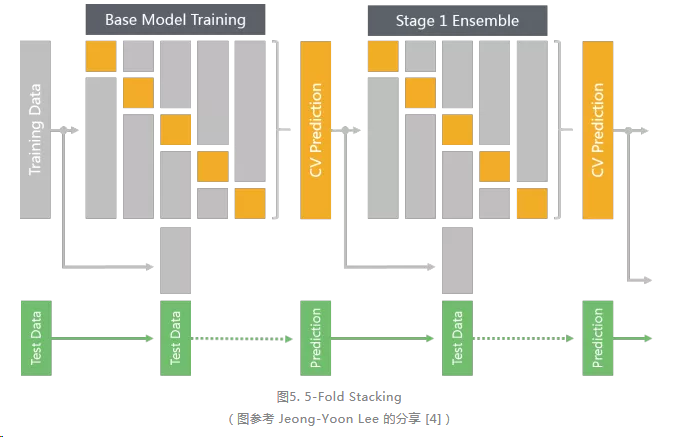

上图引自：[Jeong-Yoon Lee 的分享：Winning Data Science Competitions](https://www.slideshare.net/jeongyoonlee/winning-data-science-competitions-74391113)

图5展示了使用 5-Fold 进行一次 Stacking 的过程（当然在其上可以再叠加 Stage 2, Stage 3 等）。其主要的步骤如下：

1. 数据集划分。将训练数据按照5-Fold进行划分（如果数据跟时间有关，需要按时间划分，更一般的划分方式请参考3.4.2节，这里不再赘述）；

2. 基础模型训练 I（如图5第一行左半部分所示）。按照交叉验证（Cross Validation）的方法，在训练集（Training Fold）上面训练模型（如图灰色部分所示），并在验证集（Validation Fold）上面做预测，得到预测结果（如图黄色部分所示）。最后综合得到整个训练集上面的预测结果（如图第一个黄色部分的CV Prediction所示）。

3. 基础模型训练 II（如图5第二和三行左半部分所示）。在全量的训练集上训练模型（如图第二行灰色部分所示），并在测试集上面做预测，得到预测结果（如图第三行虚线后绿色部分所示）。

4. Stage 1 模型集成训练 I（如图5第一行右半部分所示）。将步骤 2 中得到的 CV Prediction 当作新的训练集，按照步骤 2 可以得到 Stage 1模型集成的 CV Prediction。

5. Stage 1 模型集成训练 II（如图5第二和三行右半部分所示）。将步骤 2 中得到的 CV Prediction 当作新的训练集和步骤 3 中得到的 Prediction 当作新的测试集，按照步骤 3 可以得到 Stage 1 模型集成的测试集 Prediction。此为 Stage 1 的输出，可以提交至 Kaggle 验证其效果。

在图5中，基础模型只展示了一个，而实际应用中，基础模型可以多种多样，如SVM，DNN，XGBoost 等。也可以相同的模型，不同的参数，或者不同的样本权重。重复4和5两个步骤，可以相继叠加 Stage 2, Stage 3 等模型。

#### Blending

Blending 与 Stacking 类似，但单独留出一部分数据（如 20%）用于训练 Stage X 模型。

#### Bagging Ensemble Selection

Bagging Ensemble Selection [5] 是我在 CrowdFlower 搜索相关性比赛中使用的方法，其主要的优点在于可以以优化任意的指标来进行模型集成。这些指标可以是可导的（如 LogLoss 等）和不可导的（如正确率，AUC，Quadratic Weighted Kappa等）。它是一个前向贪婪算法，存在过拟合的可能性，作者在文献 [5] 中提出了一系列的方法（如 Bagging）来降低这种风险，稳定集成模型的性能。使用这个方法，需要有成百上千的基础模型。为此，在 CrowdFlower 的比赛中，我把在调参过程中所有的中间模型以及相应的预测结果保留下来，作为基础模型。这样做的好处是，不仅仅能够找到最优的单模型（Best Single Model），而且所有的中间模型还可以参与模型集成，进一步提升效果。

参考文献：[Ensemble Selection from Libraries of Models](http://www.niculescu-mizil.org/papers/shotgun.icml04.revised.rev2.pdf)

### 自动化框架

从上面的介绍可以看到，做一个数据挖掘比赛涉及到的模块非常多，若有一个较自动化的框架会使得整个过程更加的高效。在 CrowdFlower 比赛较前期，我对整一个项目的代码架构进行了重构，抽象出来特征工程，模型调参和验证，以及模型集成等三大模块，极大的提高了尝试新特征，新模型的效率，也是我最终能斩获名次的一个有利因素。这份代码开源在 Github 上面，目前是 Github 有关 Kaggle 竞赛解决方案的 Most Stars，地址：

https://github.com/ChenglongChen/Kaggle_CrowdFlower

其主要包含以下部分：

1. 模块化特征工程

a) 接口统一，只需写少量的代码就能够生成新的特征；

b) 自动将单独的特征拼接成特征矩阵。

2. 自动化模型调参和验证

a) 自定义训练集和验证集的划分方法；

b) 使用 Grid Search / Hyperopt 等方法，对特定的模型在指定的参数空间进行调优，并记录最佳的模型参数以及相应的性能。

3. 自动化模型集成

a) 对于指定的基础模型，按照一定的方法（如Averaging/Stacking/Blending 等）生成集成模型。

## Kaggle竞赛方案盘点

###  图像分类

3.1.1 任务名称

National Data Science Bowl

3.1.2 任务详情

随着深度学习在视觉图像领域获得巨大成功，Kaggle 上面出现了越来越多跟视觉图像相关的比赛。这些比赛的发布吸引了众多参赛选手，探索基于深度学习的方法来解决垂直领域的图像问题。NDSB就是其中一个比较早期的图像分类相关的比赛。这个比赛的目标是利用提供的大量的海洋浮游生物的二值图像，通过构建模型，从而实现自动分类。

3.1.3 获奖方案

● 1st place：

Cyclic Pooling + Rolling Feature Maps + Unsupervised and Semi-Supervised Approaches。值得一提的是，这个队伍的主力队员也是Galaxy Zoo行星图像分类比赛的第一名，其也是Theano中基于FFT的Fast Conv的开发者。在两次比赛中，使用的都是 Theano，而且用的非常溜。方案链接：

http://benanne.github.io/2015/03/17/plankton.html

● 2nd place：

Deep CNN designing theory + VGG-like model + RReLU。这个队伍阵容也相当强大，有前MSRA 的研究员Xudong Cao，还有大神Tianqi Chen，Naiyan Wang，Bing XU等。Tianqi 等大神当时使用的是 CXXNet（MXNet 的前身），也在这个比赛中进行了推广。Tianqi 大神另外一个大名鼎鼎的作品就是 XGBoost，现在 Kaggle 上面几乎每场比赛的 Top 10 队伍都会使用。方案链接：

https://www.kaggle.com/c/datasciencebowl/discussion/13166

● 17th place：

Realtime data augmentation + BN + PReLU。方案链接：

https://github.com/ChenglongChen/caffe-windows

3.1.4 常用工具

▲ Theano: http://deeplearning.net/software/theano/

▲ Keras: https://keras.io/

▲ Cuda-convnet2: 

https://github.com/akrizhevsky/cuda-convnet2

▲ Caffe: http://caffe.berkeleyvision.org/

▲ CXXNET: https://github.com/dmlc/cxxnet

▲ MXNet: https://github.com/dmlc/mxnet

▲ PaddlePaddle: http://www.paddlepaddle.org/cn/index.html


###  销量预估

3.2.1 任务名称

Walmart Recruiting - Store Sales Forecasting

3.2.2 任务详情

Walmart 提供 2010-02-05 到 2012-11-01 期间的周销售记录作为训练数据，需要参赛选手建立模型预测 2012-11-02 到 2013-07-26 周销售量。比赛提供的特征数据包含：Store ID, Department ID, CPI，气温，汽油价格，失业率，是否节假日等。

3.2.3 获奖方案

● 1st place：

Time series forecasting method: stlf + arima + ets。主要是基于时序序列的统计方法，大量使用了 Rob J Hyndman 的 forecast R 包。方案链接：

https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125

● 2nd place：

Time series forecasting + ML: arima + RF + LR + PCR。时序序列的统计方法+传统机器学习方法的混合；方案链接：

https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8023

● 16th place：

Feature engineering + GBM。方案链接：

https://github.com/ChenglongChen/Kaggle_Walmart-Recruiting-Store-Sales-Forecasting

3.2.4 常用工具

▲ R forecast package: 

https://cran.r-project.org/web/packages/forecast/index.html

▲ R GBM package:

https://cran.r-project.org/web/packages/gbm/index.html


### 搜索相关性（文本）

3.3.1 任务名称

CrowdFlower Search Results Relevance

3.3.2 任务详情

比赛要求选手利用约几万个 (query, title, description) 元组的数据作为训练样本，构建模型预测其相关性打分 {1, 2, 3, 4}。比赛提供了 query, title和description的原始文本数据。比赛使用 Quadratic Weighted Kappa 作为评估标准，使得该任务有别于常见的回归和分类任务。

3.3.3 获奖方案

● 1st place：

Data Cleaning + Feature Engineering + Base Model + Ensemble。对原始文本数据进行清洗后，提取了属性特征，距离特征和基于分组的统计特征等大量的特征，使用了不同的目标函数训练不同的模型（回归，分类，排序等），最后使用模型集成的方法对不同模型的预测结果进行融合。方案链接：

https://github.com/ChenglongChen/Kaggle_CrowdFlower


3.3.4 常用工具

▲ NLTK: http://www.nltk.org/

▲ Gensim: https://radimrehurek.com/gensim/

▲ XGBoost: https://github.com/dmlc/xgboost

▲ RGF: https://github.com/baidu/fast_rgf


### 点击率预估 I

3.4.1 任务名称

Criteo Display Advertising Challenge

3.4.2 任务详情

经典的点击率预估比赛。该比赛中提供了7天的训练数据，1 天的测试数据。其中有13 个整数特征，26 个类别特征，均脱敏，因此无法知道具体特征含义。

3.4.3 获奖方案

● 1st place：

GBDT 特征编码 + FFM。台大的队伍，借鉴了[Facebook的方案](http://www.quinonero.net/Publications/predicting-clicks-facebook.pdf) ，使用 GBDT 对特征进行编码，然后将编码后的特征以及其他特征输入到 Field-aware Factorization Machine（FFM） 中进行建模。方案链接：

https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/10555

● 3rd place：

Quadratic Feature Generation + FTRL。传统特征工程和 FTRL 线性模型的结合。方案链接：

https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/10534

● 4th place：

Feature Engineering + Sparse DNN

3.4.4 常用工具

▲ Vowpal Wabbit: https://github.com/JohnLangford/vowpal_wabbit

▲ XGBoost: https://github.com/dmlc/xgboost

▲ LIBFFM: http://www.csie.ntu.edu.tw/~r01922136/libffm/


### 点击率预估 II

3.5.1 任务名称

Avazu Click-Through Rate Prediction

3.5.2 任务详情

点击率预估比赛。提供了 10 天的训练数据，1 天的测试数据，并且提供时间，banner 位置，site, app, device 特征等，8个脱敏类别特征。

3.5.3 获奖方案

● 1st place：Feature Engineering + FFM + Ensemble。还是台大的队伍，这次比赛，他们大量使用了 FFM，并只基于 FFM 进行集成。方案链接：

https://www.kaggle.com/c/avazu-ctr-prediction/discussion/12608

● 2nd place：Feature Engineering + GBDT 特征编码 + FFM + Blending。Owenzhang（曾经长时间雄霸 Kaggle 排行榜第一）的竞赛方案。Owenzhang 的特征工程做得非常有参考价值。方案链接：

https://github.com/owenzhang/kaggle-avazu

3.5.4 常用工具

▲ LIBFFM: http://www.csie.ntu.edu.tw/~r01922136/libffm/

▲ XGBoost: https://github.com/dmlc/xgboost

## 比赛的一些trick

### 适当利用 Public LB 的反馈
如图4所示，(a)和(b)表示数据与时间没有明显的关系（如图像分类），(c)和(d)表示数据随时间变化（如销量预估中的时序序列）。(a)和(b)的区别在于，训练集样本数相对于 Public LB 的量级大小，其中(a)中训练集样本数远超于 Public LB 的样本数，这种情况下基于训练集的 Local Validation 更可靠；而(b)中，训练集数目与 Public LB 相当，这种情况下，可以结合 Public LB 的反馈来指导模型的选择。一种融合的方式是根据 Local Validation 和 Public LB 的样本数目，按比例进行加权。譬如评估标准为正确率，Local Validation 的样本数为 N_l，正确率为 A_l；Public LB 的样本数为 N_p，正确率为 A_p。则可以使用融合后的指标：

（N_l * A_l + N_p * A_p）/(N_l + N_p)，来进行模型的筛选。对于(c)和(d)，由于数据分布跟时间相关，很有必要使用 Public LB 的反馈来进行模型的选择，尤其对于(c)图所示的情况。
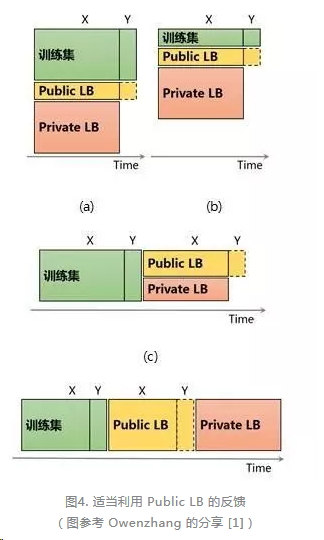

### 常用框架

编程语言：python（⭐⭐⭐⭐⭐）

炼丹框架：Pytorch（⭐⭐⭐⭐⭐）、Keras(⭐⭐⭐⭐)、Mxnet(⭐⭐⭐)、Tensorflow（⭐）

必备框架：Apex（⭐⭐⭐⭐⭐）、Numpy、Opencv、PIL、Scikit-learn、albumentations、imgaug等
> 1. 个人看来，Pytorch的易用性其实是已经超越了另外几个框架，搭建/魔改模型都非常方便；
2. Apex可以让你只写几行代码，就可以轻松使用float16或者混合精度来训练模型，显存减少将近一半的情况下，训练速度也得到大幅度提升。
3. 自写数据增强库，推荐使用Opencv；如果是封装好的数据增强库，推荐albumentations或imgaug（或torchvison.transforms），基本想得到的transform方式都包含。